# Environment setup

We start by importing the libraries and modules needed for this analysis.

In [1]:
# For reading, handling data and calculations
import os
import pandas as pd
import numpy as np
from collections import defaultdict

# For displaying images, plotting metrics, etc.
from matplotlib import pyplot as plt
import seaborn as sns

# For splitting samples into training and testing
from sklearn.model_selection import train_test_split

# PyTorch modules for building, training, and evaluating neural networks
import torch
from torch import Generator
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Sampler, WeightedRandomSampler

# Torchvision modules for computer vison and image handling
import torchvision
from torchvision import datasets, transforms

# Metrics for evaluating model performance
import torchmetrics

# For displaying commands in each cell
from IPython.core.interactiveshell import InteractiveShell

# tqdm allows us to display a progress bar for long loops
from tqdm import tqdm 

# Display output of every command in a cell
InteractiveShell.ast_node_interactivity = 'all'

# Progress bar for pandas
tqdm.pandas()

# Set seaborn style and color palette
sns.set_style('darkgrid')
my_palette = ['#D62828','#003049','#F77F00','#FCBF49','#EAE2B7','#6E9075','#EFBDEB','#1B998B','#F0F757','#777DA7']
sns.set_palette(my_palette, n_colors=10)

# Set seeds for random sampling of torch loaders
SEED_1= 24
SEED_2 = 48

In [2]:
# Device on which to train model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Read, Split, and Sample Data

In [3]:
# Root path to all images and
ROOT_PATH = '/kaggle/input/animals10/raw-img/'

# Path for all outputs
OUT_PATH = '/kaggle/working/'

# Folder for figures
FIGURE_PATH = os.path.join(OUT_PATH, 'figures')
if not os.path.exists(FIGURE_PATH):
    os.mkdir(FIGURE_PATH)

# Since animal names are in italian we will have to translate into English
translate = {'cane': 'Dog', 
             'cavallo': 'Horse', 
             'elefante': 'Elephant', 
             'farfalla': 'Butterfly', 
             'gallina': 'Chicken', 
             'gatto': 'Cat', 
             'mucca': 'Cow', 
             'pecora': 'Sheep', 
             'ragno': 'Spider', 
             'scoiattolo': 'Squirrel'
            }

As we observed when exploring the dataset in module 1, there is a large imbalance in the animal classes. This will bias the model we train and will likely lead to a model that always predicts dogs or spiders as these two classes account for almost half the images. To overcome this, we will *oversample* the minority classes when training such that there is a balanced representation of each class. This requires that some images in the minority classes will pass through the model more than once during training, which can lead to overfitting, but by augmenting the images (e.g., flipping or rotating an image) we can introduce variability into the model and reduce any overfitting. We will have to build a custom dataloader to handle all of this.

In [4]:
# Functions we need to produced class-balanced samples of our dataset

def balanced_class_weights(targets, subset_idx):
    '''Return the per-class weights needed to balance the class distributions.
    
    Each class's weight is defined as the reciprical of the class's count in the subset.
    When data are sampled from each subset with these weights, the class distribution will
    be approximately balanced for a sufficiently large sample.
    '''
    subset_idx = set(subset_idx)
    class_counts = defaultdict(int)
    for idx, target in enumerate(targets):
        if idx in subset_idx:
            class_counts[target] += 1
            
    weights = [1./count for _, count in sorted(class_counts.items())]
    return weights

def balanced_sample_weights(targets, subset_idx):
    '''Return the per-sample weights needed to balance the class distributions.
    
    Every element in the dataset will be assigned its corresponding class weight for the subset.
    Elements in the dataset outside of the subset will be assigned a weight of zero, 
    so those elements will not be sampled when the weights are passed to a sampler.
    '''
    
    # Get the weights for each class
    weights = balanced_class_weights(targets, subset_idx)
    
    # Assign the corresponding class weight to each target index in the subset 
    # and a weight of zero to target indices outside of the subset
    subset_idx = set(subset_idx)
    sample_weights = [0]*len(targets)
    for idx, target in enumerate(targets):
        if idx in subset_idx:
            sample_weights[idx] = weights[target]
            
    return sample_weights

def balanced_sampler(targets, subset_idx, num_samples, generator):
    '''Returns a random sampler weighted to balance the classes within the subset.'''
    
    # We will sample images based on the inverse of their class frequency in the subset to balance the representation of each class
    weights = balanced_sample_weights(targets, subset_idx)
    
    # The sampler will tell the dataloader to randomly sample images according to the weights we defined;
    # Images in the minority classes will be sampled more frequently than from majority classes
    sampler = WeightedRandomSampler(weights, 
                                    num_samples=num_samples,
                                    replacement=True, 
                                    generator=generator
                                   )
    return sampler

In [5]:
IMAGE_SIZE = 300
TRAIN_SPLIT = 0.8
BATCH_SIZE = 16

# Define transforms
my_transforms = transforms.Compose([transforms.ToTensor(),
                                    transforms.Pad(IMAGE_SIZE),
                                    transforms.CenterCrop(IMAGE_SIZE)
                                   ])

# Create dataset from root directory
dataset = datasets.ImageFolder(root=ROOT_PATH, transform=my_transforms)

# Get mapping from class index to English label for plot lables
dataset.class_to_idx
idx_to_label = {idx: translate[class_ita] for class_ita, idx in dataset.class_to_idx.items()}

# Split the dataset into training and testing subsets; return indices of subsets
train_idx, test_idx = train_test_split(np.arange(len(dataset.targets)), 
                                       train_size=TRAIN_SPLIT,  
                                       random_state=SEED_1, 
                                       shuffle=True, 
                                       stratify=dataset.targets
                                      )

{'cane': 0,
 'cavallo': 1,
 'elefante': 2,
 'farfalla': 3,
 'gallina': 4,
 'gatto': 5,
 'mucca': 6,
 'pecora': 7,
 'ragno': 8,
 'scoiattolo': 9}

Let's validate that the samplers are producing balanced subsets.

In [6]:
# Samplers to oversample the train or test set such that the classes are balanced
tmp_train_sampler = balanced_sampler(dataset.targets,
                                     subset_idx=train_idx,
                                     num_samples=1600,
                                     generator=Generator('cpu').manual_seed(SEED_1)
                                    )

tmp_test_sampler = balanced_sampler(dataset.targets,
                                    subset_idx=test_idx,
                                    num_samples=1600,
                                    generator=Generator('cpu').manual_seed(SEED_2)
                                   )

# Dataloaders to randomly sample each train/test dataset in batches
tmp_train_loader = DataLoader(dataset, sampler=tmp_train_sampler, batch_size=BATCH_SIZE)
tmp_test_loader = DataLoader(dataset, sampler=tmp_test_sampler, batch_size=BATCH_SIZE)

# Get the class label for each target and load into pandas dataframe for analysis/plotting
tmp_train_counts = np.array([label for label in [labels.tolist() for _, labels in tqdm(tmp_train_loader)]]).flatten()
tmp_test_counts = np.array([label for label in [labels.tolist() for _, labels in tqdm(tmp_test_loader)]]).flatten()

df_train = pd.DataFrame({'class_idx': tmp_train_counts})
df_test = pd.DataFrame({'class_idx': tmp_test_counts})

df_train['label'] = df_train['class_idx'].apply(lambda x: idx_to_label[x])
df_test['label'] = df_test['class_idx'].apply(lambda x: idx_to_label[x])

df_train_counts = df_train['label'].value_counts()
df_test_counts = df_test['label'].value_counts()

# Inspect the dfs
df_train_counts
df_test_counts

100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


label
Cow          174
Chicken      168
Elephant     166
Sheep        166
Spider       163
Squirrel     160
Horse        157
Butterfly    157
Dog          150
Cat          139
Name: count, dtype: int64

label
Cow          181
Elephant     174
Cat          167
Chicken      167
Squirrel     165
Sheep        164
Horse        164
Spider       154
Dog          133
Butterfly    131
Name: count, dtype: int64

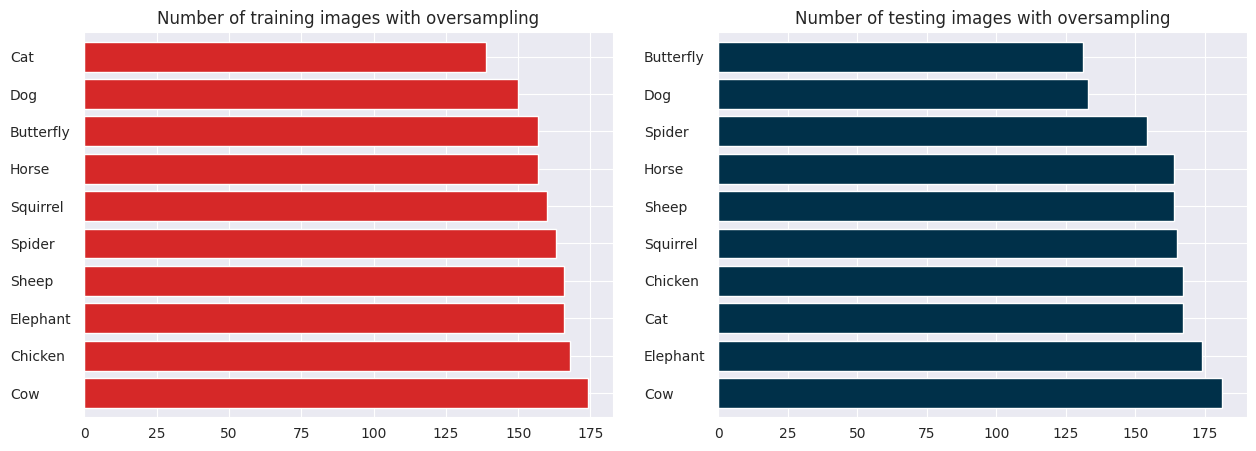

In [7]:
# Create fig and subplots
fig, ax = plt.subplots(ncols=2, figsize=(15,5))

df_train_counts.plot(kind='barh', title='Number of training images with oversampling', width=.8, color=my_palette[0], ax=ax[0])
df_test_counts.plot(kind='barh', title='Number of testing images with oversampling', width=.8, color=my_palette[1], ax=ax[1])

# Clean up y-axis labels
ax[0].set(ylabel=None)
ax[1].set(ylabel=None)

ax[0].tick_params(axis='y', pad=50)  
ax[1].tick_params(axis='y', pad=50)  

ax[0].set_yticklabels(ax[0].get_yticklabels(), ha='left')
ax[1].set_yticklabels(ax[1].get_yticklabels(), ha='left')

# Save figure
plt.savefig(os.path.join(FIGURE_PATH,'validate-balanced-classes.pdf'), bbox_inches='tight');

As we can see from the bar charts of the training and testing samples, the classes are much more balanced than before by oversampling the minority classes. This will reduce the class bias when training our model. 

Now create data loaders with a larger sample size for the actual analysis.

In [8]:
# Samplers to oversample the train or test set such that the classes are balanced
train_sampler = balanced_sampler(dataset.targets,
                                 subset_idx=train_idx,
                                 num_samples=len(train_idx),
                                 generator=Generator('cpu').manual_seed(SEED_1)
                                )

test_sampler = balanced_sampler(dataset.targets,
                                subset_idx=test_idx,
                                num_samples=len(test_idx),
                                generator=Generator('cpu').manual_seed(SEED_2)
                               )

# Dataloaders to randomly sample each train/test dataset in batches
train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

# Building the Neural Network

Now we will build the model and specify the hyperparameters. 

The model we will use is a Convolutional Neural Network (CNN). Our model will subclass `Module` from the `torch` library and consist of:

* One convolution layer with a 5 x 5 kernel, 6 features, and a stride of 1
* One 2 x 2 max pooling layer with a stride of 2
* A second convolution layer with a 5 x 5 kernel, 16 features, and a stride of 1
* A second 2 x 2 pooling layer with a stride of 2
* Three fully-connected layers reducing the dimensions from 82944 -> 120 -> 84 -> 10
* All convolution and fully-connected layer logits are passed through the ReLu activation function
* The final 1 x 10 dimensional output layer is passed through the softmax function to return probabilities

In [9]:
# Now build the image classifier with a Convolutional Neural Network (CNN)

class ImageClassifier(nn.Module):
    '''Convolutional Neural Network for classifying images into 1 of 10 classes.'''
    
    def __init__(self):
        '''Initialize the CNN and define the layers.'''
        super().__init__()
        
        # Input -> 3 x 300 x 300 (RBG channels, pixel height, pixel width)
        self.conv1 = nn.Conv2d(3, 6, 5) 
        # Conv1 -> 6 x 296 x 296 : where ((300 - 5)/1) + 1 = 296
        self.pool = nn.MaxPool2d(2, 2)
        # Pool1 -> 6 x 148 x 148 : where ((296 - 2)/2) + 1 = 148
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Conv2 -> 16 x 144 x 144 : where ((144 - 5)/1) + 1 = 144
        # Pool2 -> 16 x 72 x 72 : where ((144 - 2)/2) + 1 = 72
        # flatten -> 82944 : where 16 * 72 * 72 = 82944
        # Fully-connected layers
        self.fc1 = nn.Linear(16 * 72 * 72, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        '''Forward propogation of image through model.'''
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1) # flatten dimensions (start_dim=1 to keep batches)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1) 
        return x


my_model = ImageClassifier().to(device)
my_model

ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

We will start by training 10 epochs with a learning rate of 0.001 and momentum of 0.9.

# Training the Neural Network

In [10]:
# Set the training hyperparameters
EPOCHS = 10 # number of gradient descent passes in the model fitting
LEARNING_RATE = 0.001 # size of each step in gradient descent procedure
MOMENTUM = 0.9 # Momentum, speeds up training

Now we will decide how the model will be trained. We need to select a loss function: the metric by which to measure if the model has improved or worsened after adjusting the weights and biases. We also need to select an optimizer: a `torch` object that will store the model state, compute and the gradients (backpropgation) and updates the model weights.

For the loss function we will use `CrossEntropyLoss` which is a function used when building a classifier.

For the optimizer we will use `StochasticGradientDescent` that will perform stochastic gradient descent when computing the gradients.

In [12]:
ce_loss = nn.CrossEntropyLoss()
sgd_opt = optim.SGD(my_model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

accuracy_metric = torchmetrics.Accuracy(task='multilabel', num_labels=10).to(device)
cm_metric = torchmetrics.ConfusionMatrix(task='multilabel', num_labels=10).to(device)

Let's define a function that will train a model over one epoch by looping through each mini-batch. 

A rough brakdown of each loop is:
* Grab the current mini-batch of inputs/targets
* Encode the class indices of the targets to one-hot vectors
* Set the gradients in the model to zero
* Pass the inputs to the model and get the predictions
* Get the accuracy of the model
* Get the current loss and backpropagate to estimate the model's gradients
* Update the model weights that minimize the loss

In [13]:
# Fitting procedure for a single epoch
def FitModel(dataloader, model, loss_fn, optimizer, epoch):

    total_loss = 0.0
    running_loss = 0.0

    # Set model to training mode
    model.train()

    # loop through training data one mini-batch at a time
    for minibatch, data in enumerate(dataloader):

        # Get input and label data for the current batch
        inputs, targets = data
        
        # Convert target indices to one-hot tensors
        targets = F.one_hot(targets, num_classes=10).float()
        
        # move tensors from cpu to gpU
        if device.type == 'cuda':
            inputs, targets = inputs.cuda(), targets.cuda()

        # Zero-out the parameter gradients before forward propogating
        optimizer.zero_grad()

        # Pass the input data forward through the model and get the predictions
        predictions = model(inputs)
        
        # Compute the accuracy for this mini-batch
        accuracy = accuracy_metric(predictions, targets)

        # Compute the loss by comparing the predictions with the targets
        # We need to on-hot encode the class labels to compare with the predictions
        loss = loss_fn(predictions, targets)
        
        # Incriment the total and running losses
        total_loss += loss.item()/len(dataloader)
        running_loss += loss.item()/100
        
        # Compute the gradients of the loss function
        # by back-propagating each operation performed by the model
        loss.backward()

        # Modify the learning weights such that the gradient is minimized
        optimizer.step()
        
        # For tracking progress every 2000 mini-batches
        if minibatch % 100 == 99:
            print(f'epoch: {epoch+1} | mini-batch: {minibatch+1}/{len(dataloader)} | loss: {running_loss / 100}')
            
            # Reset the running loss
            running_loss = 0.0

    return total_loss

Now we train the model and save the weights following each epoch as a separate model for evaluation in the next notebook.

In [14]:
# Folder for models
MODEL_PATH = os.path.join(OUT_PATH, 'models')
if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

# Loop over each training epoch
for epoch in range(EPOCHS):
    print(f'Training epoch {epoch+1}')
    
    # Fit the model and get the losses
    train_loss = FitModel(train_loader, my_model, ce_loss, sgd_opt, epoch)
    
    train_acc = accuracy_metric.compute()
    print(f'Training accuracy: {train_acc:.2f}')
    
    # Reset the accuracy
    accuracy_metric.reset()
    
    # Save the model
    saved_model = torch.save(my_model.cpu().state_dict(), os.path.join(MODEL_PATH, f'model_{epoch+1}.pth'))
    
    # moving model to GPU for further training
    if device.type == 'cuda':
        my_model.cuda()

Training epoch 1
epoch: 1 | mini-batch: 100/1309 | loss: 0.02302487895488739
epoch: 1 | mini-batch: 200/1309 | loss: 0.023024449253082273
epoch: 1 | mini-batch: 300/1309 | loss: 0.023024626612663263
epoch: 1 | mini-batch: 400/1309 | loss: 0.023023905706405636
epoch: 1 | mini-batch: 500/1309 | loss: 0.023017488694190985
epoch: 1 | mini-batch: 600/1309 | loss: 0.023025070357322694
epoch: 1 | mini-batch: 700/1309 | loss: 0.023016429686546328
epoch: 1 | mini-batch: 800/1309 | loss: 0.023020344424247746
epoch: 1 | mini-batch: 900/1309 | loss: 0.0230149393081665
epoch: 1 | mini-batch: 1000/1309 | loss: 0.023013847017288196
epoch: 1 | mini-batch: 1100/1309 | loss: 0.02300835602283478
epoch: 1 | mini-batch: 1200/1309 | loss: 0.023015385508537295
epoch: 1 | mini-batch: 1300/1309 | loss: 0.023005284404754644
Training accuracy: 0.90


ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 2
epoch: 2 | mini-batch: 100/1309 | loss: 0.023008068585395808
epoch: 2 | mini-batch: 200/1309 | loss: 0.02299063599109649
epoch: 2 | mini-batch: 300/1309 | loss: 0.022985383987426767
epoch: 2 | mini-batch: 400/1309 | loss: 0.02297168662548067
epoch: 2 | mini-batch: 500/1309 | loss: 0.022958513998985287
epoch: 2 | mini-batch: 600/1309 | loss: 0.022919769859313967
epoch: 2 | mini-batch: 700/1309 | loss: 0.022860816645622263
epoch: 2 | mini-batch: 800/1309 | loss: 0.02281728932857514
epoch: 2 | mini-batch: 900/1309 | loss: 0.02278204190731048
epoch: 2 | mini-batch: 1000/1309 | loss: 0.02269286844730377
epoch: 2 | mini-batch: 1100/1309 | loss: 0.022610144782066344
epoch: 2 | mini-batch: 1200/1309 | loss: 0.02253831007480622
epoch: 2 | mini-batch: 1300/1309 | loss: 0.0226796911239624
Training accuracy: 0.89


ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 3
epoch: 3 | mini-batch: 100/1309 | loss: 0.02238866372108459
epoch: 3 | mini-batch: 200/1309 | loss: 0.022525696158409114
epoch: 3 | mini-batch: 300/1309 | loss: 0.022358804082870484
epoch: 3 | mini-batch: 400/1309 | loss: 0.022442028427124016
epoch: 3 | mini-batch: 500/1309 | loss: 0.02238842949867249
epoch: 3 | mini-batch: 600/1309 | loss: 0.022410943722724914
epoch: 3 | mini-batch: 700/1309 | loss: 0.022291090440750127
epoch: 3 | mini-batch: 800/1309 | loss: 0.022327813887596134
epoch: 3 | mini-batch: 900/1309 | loss: 0.022219437122344973
epoch: 3 | mini-batch: 1000/1309 | loss: 0.02225794718265533
epoch: 3 | mini-batch: 1100/1309 | loss: 0.022378693675994866
epoch: 3 | mini-batch: 1200/1309 | loss: 0.022269902896881102
epoch: 3 | mini-batch: 1300/1309 | loss: 0.022286742854118347
Training accuracy: 0.86


ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 4
epoch: 4 | mini-batch: 100/1309 | loss: 0.021992827534675588
epoch: 4 | mini-batch: 200/1309 | loss: 0.022250398218631742
epoch: 4 | mini-batch: 300/1309 | loss: 0.022154314279556265
epoch: 4 | mini-batch: 400/1309 | loss: 0.0221428403377533
epoch: 4 | mini-batch: 500/1309 | loss: 0.022129060721397392
epoch: 4 | mini-batch: 600/1309 | loss: 0.022008433914184576
epoch: 4 | mini-batch: 700/1309 | loss: 0.021955976247787477
epoch: 4 | mini-batch: 800/1309 | loss: 0.021986808538436896
epoch: 4 | mini-batch: 900/1309 | loss: 0.021890626776218412
epoch: 4 | mini-batch: 1000/1309 | loss: 0.02205901145935059
epoch: 4 | mini-batch: 1100/1309 | loss: 0.02203747291564941
epoch: 4 | mini-batch: 1200/1309 | loss: 0.021999840664863587
epoch: 4 | mini-batch: 1300/1309 | loss: 0.0219528594493866
Training accuracy: 0.86


ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 5
epoch: 5 | mini-batch: 100/1309 | loss: 0.021998061680793757
epoch: 5 | mini-batch: 200/1309 | loss: 0.02177086809873581
epoch: 5 | mini-batch: 300/1309 | loss: 0.022065035426616662
epoch: 5 | mini-batch: 400/1309 | loss: 0.02200020627975463
epoch: 5 | mini-batch: 500/1309 | loss: 0.02184249356985091
epoch: 5 | mini-batch: 600/1309 | loss: 0.02201044498682022
epoch: 5 | mini-batch: 700/1309 | loss: 0.021925498449802395
epoch: 5 | mini-batch: 800/1309 | loss: 0.021768918228149418
epoch: 5 | mini-batch: 900/1309 | loss: 0.02193566684722901
epoch: 5 | mini-batch: 1000/1309 | loss: 0.021700458061695103
epoch: 5 | mini-batch: 1100/1309 | loss: 0.021591520774364478
epoch: 5 | mini-batch: 1200/1309 | loss: 0.021819521832466125
epoch: 5 | mini-batch: 1300/1309 | loss: 0.021776760351657872
Training accuracy: 0.86


ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 6
epoch: 6 | mini-batch: 100/1309 | loss: 0.02189594304561616
epoch: 6 | mini-batch: 200/1309 | loss: 0.02176074919700623
epoch: 6 | mini-batch: 300/1309 | loss: 0.021880439567565923
epoch: 6 | mini-batch: 400/1309 | loss: 0.02167391855716706
epoch: 6 | mini-batch: 500/1309 | loss: 0.02175997061729431
epoch: 6 | mini-batch: 600/1309 | loss: 0.021738092923164358
epoch: 6 | mini-batch: 700/1309 | loss: 0.02171931850910188
epoch: 6 | mini-batch: 800/1309 | loss: 0.02149003276824952
epoch: 6 | mini-batch: 900/1309 | loss: 0.021720149838924407
epoch: 6 | mini-batch: 1000/1309 | loss: 0.02176609092950822
epoch: 6 | mini-batch: 1100/1309 | loss: 0.02165913769006729
epoch: 6 | mini-batch: 1200/1309 | loss: 0.02177369490861894
epoch: 6 | mini-batch: 1300/1309 | loss: 0.021927249741554272
Training accuracy: 0.86


ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 7
epoch: 7 | mini-batch: 100/1309 | loss: 0.021541966176033017
epoch: 7 | mini-batch: 200/1309 | loss: 0.021606602811813355
epoch: 7 | mini-batch: 300/1309 | loss: 0.02158477156162262
epoch: 7 | mini-batch: 400/1309 | loss: 0.021482237589359285
epoch: 7 | mini-batch: 500/1309 | loss: 0.02166165182590485
epoch: 7 | mini-batch: 600/1309 | loss: 0.021749299871921545
epoch: 7 | mini-batch: 700/1309 | loss: 0.021535664641857147
epoch: 7 | mini-batch: 800/1309 | loss: 0.021588765978813176
epoch: 7 | mini-batch: 900/1309 | loss: 0.02160633579492569
epoch: 7 | mini-batch: 1000/1309 | loss: 0.02149164767265321
epoch: 7 | mini-batch: 1100/1309 | loss: 0.02134396846294403
epoch: 7 | mini-batch: 1200/1309 | loss: 0.02149397825002671
epoch: 7 | mini-batch: 1300/1309 | loss: 0.021515262436866755
Training accuracy: 0.87


ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 8
epoch: 8 | mini-batch: 100/1309 | loss: 0.021528669190406795
epoch: 8 | mini-batch: 200/1309 | loss: 0.021368315982818603
epoch: 8 | mini-batch: 300/1309 | loss: 0.02147856121063233
epoch: 8 | mini-batch: 400/1309 | loss: 0.021647154760360707
epoch: 8 | mini-batch: 500/1309 | loss: 0.0213022305727005
epoch: 8 | mini-batch: 600/1309 | loss: 0.02143153427839279
epoch: 8 | mini-batch: 700/1309 | loss: 0.021267051553726195
epoch: 8 | mini-batch: 800/1309 | loss: 0.02175728594064712
epoch: 8 | mini-batch: 900/1309 | loss: 0.021249641108512886
epoch: 8 | mini-batch: 1000/1309 | loss: 0.021337906086444862
epoch: 8 | mini-batch: 1100/1309 | loss: 0.02147412071228028
epoch: 8 | mini-batch: 1200/1309 | loss: 0.021537160193920137
epoch: 8 | mini-batch: 1300/1309 | loss: 0.021132721447944643
Training accuracy: 0.87


ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 9
epoch: 9 | mini-batch: 100/1309 | loss: 0.02149793121814728
epoch: 9 | mini-batch: 200/1309 | loss: 0.021330520474910748
epoch: 9 | mini-batch: 300/1309 | loss: 0.021381685674190524
epoch: 9 | mini-batch: 400/1309 | loss: 0.021328424441814424
epoch: 9 | mini-batch: 500/1309 | loss: 0.021163823568820947
epoch: 9 | mini-batch: 600/1309 | loss: 0.02129846241474151
epoch: 9 | mini-batch: 700/1309 | loss: 0.021024765276908875
epoch: 9 | mini-batch: 800/1309 | loss: 0.021276429867744445
epoch: 9 | mini-batch: 900/1309 | loss: 0.02126880104541779
epoch: 9 | mini-batch: 1000/1309 | loss: 0.021148649203777313
epoch: 9 | mini-batch: 1100/1309 | loss: 0.021109229362010953
epoch: 9 | mini-batch: 1200/1309 | loss: 0.02095144007205964
epoch: 9 | mini-batch: 1300/1309 | loss: 0.02133214881420136
Training accuracy: 0.87


ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Training epoch 10
epoch: 10 | mini-batch: 100/1309 | loss: 0.021123070836067202
epoch: 10 | mini-batch: 200/1309 | loss: 0.020986131656169884
epoch: 10 | mini-batch: 300/1309 | loss: 0.020945161473751073
epoch: 10 | mini-batch: 400/1309 | loss: 0.021192306280136103
epoch: 10 | mini-batch: 500/1309 | loss: 0.021169344162940983
epoch: 10 | mini-batch: 600/1309 | loss: 0.02117640770673753
epoch: 10 | mini-batch: 700/1309 | loss: 0.021168457460403443
epoch: 10 | mini-batch: 800/1309 | loss: 0.021081248593330385
epoch: 10 | mini-batch: 900/1309 | loss: 0.02118688746690749
epoch: 10 | mini-batch: 1000/1309 | loss: 0.020917079234123236
epoch: 10 | mini-batch: 1100/1309 | loss: 0.02089322707653046
epoch: 10 | mini-batch: 1200/1309 | loss: 0.020978975117206578
epoch: 10 | mini-batch: 1300/1309 | loss: 0.020979875826835623
Training accuracy: 0.87


ImageClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=82944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

# Model Evaluation

We will now load each saved model and evaluate the performance by comparing the loss, accuracy, and other metrics for each model.

We start by defining the evaluation loop--almost identical to the training loop, except that that no backpropogation is performed.

In [18]:
# Evaluation for a single epoch
def EvaluateModel(dataloader, model, loss_fn, epoch):
    
    total_loss = 0.0
    running_loss = 0.0

    # Set model to eval mode
    model.eval()

    # Evaluate model without computing gradients
    with torch.no_grad():

        # loop through data one batch at a time
        for minibatch, data in enumerate(dataloader):

            # Get input and label data for the current batch
            inputs, targets = data
            
            # Convert target indices to one-hot tensors
            targets = F.one_hot(targets, num_classes=10).float()
            
            # move tensors from cpu to gpu
            if device.type == 'cuda':
                inputs, targets = inputs.cuda(), targets.cuda()

            # Pass the input data through the model and get the predictors
            predictions = model(inputs)
            
            # Get the loss function of the validation set
            loss = loss_fn(predictions, targets)
            total_loss += loss.item()/len(dataloader)
            running_loss += loss.item()/50

            # compute the accuracy for this batch
            accuracy = accuracy_metric(predictions, targets)
            
            # compute the confusion matrix for this batch
            confusion_matrix = cm_metric(predictions, targets.long())
            
            # For tracking progress every 2000 mini-batches
            if minibatch % 50 == 49:
                print(f'epoch: {epoch+1} | mini-batch: {minibatch+1}/{len(dataloader)} | loss: {running_loss / 50}')
            
                # Reset the running loss
                running_loss = 0.0
            
    return total_loss

Evaluate the performance of each model on the training and testing datasets.

In [19]:
epochs = []

train_accuracy = []
test_accuracy = []

train_losses = []
test_losses = []

train_confusion_matrix = []
test_confusion_matrix = []

# Evaluate the model
for epoch in range(EPOCHS):
    print(f'Testing epoch {epoch+1}')
    epochs.append(epoch+1)
    
    # Path of model to load
    load_path = os.path.join(MODEL_PATH, f'model_{epoch+1}.pth')
    
    # Load the appropriate model
    my_model.load_state_dict(torch.load(load_path))

    # Evaluate model with training data
    train_loss = EvaluateModel(train_loader, my_model, ce_loss, epoch)
    train_losses.append(train_loss)
    
    # save accuracy for plotting
    train_acc = accuracy_metric.compute()
    train_accuracy.append(train_acc.cpu())
    print(f'Training accuracy: {train_acc:.2f}')
    
    train_cm = cm_metric.compute()
    train_confusion_matrix.append(train_cm.cpu())
    print(f'Training confusion matrix: {train_cm}')

    # Reset the accuracy
    accuracy_metric.reset()
    cm_metric.reset()

    # Evaluate model with validation data
    test_loss = EvaluateModel(test_loader, my_model, ce_loss, epoch)
    test_losses.append(test_loss)
    
    # save accuracy for plotting
    test_acc = accuracy_metric.compute()
    test_accuracy.append(test_acc.cpu())
    print(f'Testing accuracy: {test_acc:.2f}')
    
    test_cm = cm_metric.compute()
    test_confusion_matrix.append(test_cm.cpu())
    print(f'Testing confusion matrix: {test_cm}')

    # Reset the accuracy
    accuracy_metric.reset()
    cm_metric.reset()

Testing epoch 1


<All keys matched successfully>

epoch: 1 | mini-batch: 50/1309 | loss: 0.046009140491485606
epoch: 1 | mini-batch: 100/1309 | loss: 0.04600576763153077
epoch: 1 | mini-batch: 150/1309 | loss: 0.046012156486511226
epoch: 1 | mini-batch: 200/1309 | loss: 0.04600212402343749
epoch: 1 | mini-batch: 250/1309 | loss: 0.046017307281494134
epoch: 1 | mini-batch: 300/1309 | loss: 0.04600332889556883
epoch: 1 | mini-batch: 350/1309 | loss: 0.04600409965515138
epoch: 1 | mini-batch: 400/1309 | loss: 0.04598556547164917
epoch: 1 | mini-batch: 450/1309 | loss: 0.0460032377243042
epoch: 1 | mini-batch: 500/1309 | loss: 0.04599518432617188
epoch: 1 | mini-batch: 550/1309 | loss: 0.04600719375610352
epoch: 1 | mini-batch: 600/1309 | loss: 0.04601669282913206
epoch: 1 | mini-batch: 650/1309 | loss: 0.046011242580413815
epoch: 1 | mini-batch: 700/1309 | loss: 0.04601004276275635
epoch: 1 | mini-batch: 750/1309 | loss: 0.04599003419876099
epoch: 1 | mini-batch: 800/1309 | loss: 0.046013856315612785
epoch: 1 | mini-batch: 850/1309 | los

<All keys matched successfully>

epoch: 2 | mini-batch: 50/1309 | loss: 0.0453257392883301
epoch: 2 | mini-batch: 100/1309 | loss: 0.04515585298538207
epoch: 2 | mini-batch: 150/1309 | loss: 0.044965100765228264
epoch: 2 | mini-batch: 200/1309 | loss: 0.044885339260101326
epoch: 2 | mini-batch: 250/1309 | loss: 0.045127142715454094
epoch: 2 | mini-batch: 300/1309 | loss: 0.04502504453659057
epoch: 2 | mini-batch: 350/1309 | loss: 0.044912211418151854
epoch: 2 | mini-batch: 400/1309 | loss: 0.04473812398910523
epoch: 2 | mini-batch: 450/1309 | loss: 0.04497695341110228
epoch: 2 | mini-batch: 500/1309 | loss: 0.04510953226089476
epoch: 2 | mini-batch: 550/1309 | loss: 0.04534763488769533
epoch: 2 | mini-batch: 600/1309 | loss: 0.04505441503524779
epoch: 2 | mini-batch: 650/1309 | loss: 0.04494787387847901
epoch: 2 | mini-batch: 700/1309 | loss: 0.0448601369857788
epoch: 2 | mini-batch: 750/1309 | loss: 0.04502700510025024
epoch: 2 | mini-batch: 800/1309 | loss: 0.045266011810302736
epoch: 2 | mini-batch: 850/1309 | loss

<All keys matched successfully>

epoch: 3 | mini-batch: 50/1309 | loss: 0.04438177843093872
epoch: 3 | mini-batch: 100/1309 | loss: 0.04413487949371337
epoch: 3 | mini-batch: 150/1309 | loss: 0.044613938045501705
epoch: 3 | mini-batch: 200/1309 | loss: 0.04427622280120849
epoch: 3 | mini-batch: 250/1309 | loss: 0.04415485086441039
epoch: 3 | mini-batch: 300/1309 | loss: 0.04423723735809326
epoch: 3 | mini-batch: 350/1309 | loss: 0.044116205024719225
epoch: 3 | mini-batch: 400/1309 | loss: 0.044218765449523925
epoch: 3 | mini-batch: 450/1309 | loss: 0.044380571842193614
epoch: 3 | mini-batch: 500/1309 | loss: 0.044248414230346686
epoch: 3 | mini-batch: 550/1309 | loss: 0.04389843950271606
epoch: 3 | mini-batch: 600/1309 | loss: 0.04434339466094971
epoch: 3 | mini-batch: 650/1309 | loss: 0.04438881855010987
epoch: 3 | mini-batch: 700/1309 | loss: 0.04433706922531127
epoch: 3 | mini-batch: 750/1309 | loss: 0.04466342639923097
epoch: 3 | mini-batch: 800/1309 | loss: 0.04449405641555787
epoch: 3 | mini-batch: 850/1309 | lo

<All keys matched successfully>

epoch: 4 | mini-batch: 50/1309 | loss: 0.04418913164138794
epoch: 4 | mini-batch: 100/1309 | loss: 0.044323620319366465
epoch: 4 | mini-batch: 150/1309 | loss: 0.044001570796966545
epoch: 4 | mini-batch: 200/1309 | loss: 0.04396342601776124
epoch: 4 | mini-batch: 250/1309 | loss: 0.044164655637741086
epoch: 4 | mini-batch: 300/1309 | loss: 0.043709142112731934
epoch: 4 | mini-batch: 350/1309 | loss: 0.04370301837921141
epoch: 4 | mini-batch: 400/1309 | loss: 0.044201253795623785
epoch: 4 | mini-batch: 450/1309 | loss: 0.044162302970886226
epoch: 4 | mini-batch: 500/1309 | loss: 0.0441132526874542
epoch: 4 | mini-batch: 550/1309 | loss: 0.04440092630386354
epoch: 4 | mini-batch: 600/1309 | loss: 0.044105118465423566
epoch: 4 | mini-batch: 650/1309 | loss: 0.04431700143814087
epoch: 4 | mini-batch: 700/1309 | loss: 0.04378405351638794
epoch: 4 | mini-batch: 750/1309 | loss: 0.04360572247505189
epoch: 4 | mini-batch: 800/1309 | loss: 0.04376065907478334
epoch: 4 | mini-batch: 850/1309 | l

<All keys matched successfully>

epoch: 5 | mini-batch: 50/1309 | loss: 0.04321711778640747
epoch: 5 | mini-batch: 100/1309 | loss: 0.04351109514236448
epoch: 5 | mini-batch: 150/1309 | loss: 0.0435057610988617
epoch: 5 | mini-batch: 200/1309 | loss: 0.04339541311264036
epoch: 5 | mini-batch: 250/1309 | loss: 0.04334528899192811
epoch: 5 | mini-batch: 300/1309 | loss: 0.04343280200958252
epoch: 5 | mini-batch: 350/1309 | loss: 0.04319697942733765
epoch: 5 | mini-batch: 400/1309 | loss: 0.04357816247940065
epoch: 5 | mini-batch: 450/1309 | loss: 0.043604994773864744
epoch: 5 | mini-batch: 500/1309 | loss: 0.04310527625083924
epoch: 5 | mini-batch: 550/1309 | loss: 0.04321667428016663
epoch: 5 | mini-batch: 600/1309 | loss: 0.04316482849121093
epoch: 5 | mini-batch: 650/1309 | loss: 0.043535560941696166
epoch: 5 | mini-batch: 700/1309 | loss: 0.04362267351150512
epoch: 5 | mini-batch: 750/1309 | loss: 0.04300222473144531
epoch: 5 | mini-batch: 800/1309 | loss: 0.04337133097648621
epoch: 5 | mini-batch: 850/1309 | loss: 

<All keys matched successfully>

epoch: 6 | mini-batch: 50/1309 | loss: 0.04308880062103272
epoch: 6 | mini-batch: 100/1309 | loss: 0.0435846221923828
epoch: 6 | mini-batch: 150/1309 | loss: 0.04319597911834716
epoch: 6 | mini-batch: 200/1309 | loss: 0.04311283149719239
epoch: 6 | mini-batch: 250/1309 | loss: 0.043157388210296646
epoch: 6 | mini-batch: 300/1309 | loss: 0.04325236902236939
epoch: 6 | mini-batch: 350/1309 | loss: 0.04282576675415039
epoch: 6 | mini-batch: 400/1309 | loss: 0.043263693428039554
epoch: 6 | mini-batch: 450/1309 | loss: 0.04353971753120422
epoch: 6 | mini-batch: 500/1309 | loss: 0.04343327636718751
epoch: 6 | mini-batch: 550/1309 | loss: 0.04304779486656188
epoch: 6 | mini-batch: 600/1309 | loss: 0.04310837516784668
epoch: 6 | mini-batch: 650/1309 | loss: 0.04357010917663575
epoch: 6 | mini-batch: 700/1309 | loss: 0.04275681219100952
epoch: 6 | mini-batch: 750/1309 | loss: 0.04324659614562987
epoch: 6 | mini-batch: 800/1309 | loss: 0.043578167343139664
epoch: 6 | mini-batch: 850/1309 | loss:

<All keys matched successfully>

epoch: 7 | mini-batch: 50/1309 | loss: 0.043242162084579455
epoch: 7 | mini-batch: 100/1309 | loss: 0.04290279288291931
epoch: 7 | mini-batch: 150/1309 | loss: 0.04327401099205019
epoch: 7 | mini-batch: 200/1309 | loss: 0.042638273906707776
epoch: 7 | mini-batch: 250/1309 | loss: 0.042908207321166986
epoch: 7 | mini-batch: 300/1309 | loss: 0.042249192428588885
epoch: 7 | mini-batch: 350/1309 | loss: 0.0427277000427246
epoch: 7 | mini-batch: 400/1309 | loss: 0.04295837621688842
epoch: 7 | mini-batch: 450/1309 | loss: 0.04257743244171142
epoch: 7 | mini-batch: 500/1309 | loss: 0.04261286888122559
epoch: 7 | mini-batch: 550/1309 | loss: 0.042708935451507564
epoch: 7 | mini-batch: 600/1309 | loss: 0.042392528724670406
epoch: 7 | mini-batch: 650/1309 | loss: 0.0428845989227295
epoch: 7 | mini-batch: 700/1309 | loss: 0.04266294202804565
epoch: 7 | mini-batch: 750/1309 | loss: 0.043427213001251214
epoch: 7 | mini-batch: 800/1309 | loss: 0.0429394121170044
epoch: 7 | mini-batch: 850/1309 | los

<All keys matched successfully>

epoch: 8 | mini-batch: 50/1309 | loss: 0.04284365253448488
epoch: 8 | mini-batch: 100/1309 | loss: 0.04219635281562805
epoch: 8 | mini-batch: 150/1309 | loss: 0.04239598884582519
epoch: 8 | mini-batch: 200/1309 | loss: 0.042989717006683345
epoch: 8 | mini-batch: 250/1309 | loss: 0.042886533308029176
epoch: 8 | mini-batch: 300/1309 | loss: 0.04288683319091796
epoch: 8 | mini-batch: 350/1309 | loss: 0.0423187825679779
epoch: 8 | mini-batch: 400/1309 | loss: 0.04274208283424377
epoch: 8 | mini-batch: 450/1309 | loss: 0.04263676552772521
epoch: 8 | mini-batch: 500/1309 | loss: 0.04225701427459717
epoch: 8 | mini-batch: 550/1309 | loss: 0.04252402148246765
epoch: 8 | mini-batch: 600/1309 | loss: 0.04295391440391541
epoch: 8 | mini-batch: 650/1309 | loss: 0.04235566735267638
epoch: 8 | mini-batch: 700/1309 | loss: 0.04269360289573669
epoch: 8 | mini-batch: 750/1309 | loss: 0.042328382968902595
epoch: 8 | mini-batch: 800/1309 | loss: 0.04262366261482238
epoch: 8 | mini-batch: 850/1309 | loss:

<All keys matched successfully>

epoch: 9 | mini-batch: 50/1309 | loss: 0.04253251266479492
epoch: 9 | mini-batch: 100/1309 | loss: 0.042105130386352545
epoch: 9 | mini-batch: 150/1309 | loss: 0.04188619961738586
epoch: 9 | mini-batch: 200/1309 | loss: 0.042140267372131335
epoch: 9 | mini-batch: 250/1309 | loss: 0.04243325862884521
epoch: 9 | mini-batch: 300/1309 | loss: 0.04239288516044616
epoch: 9 | mini-batch: 350/1309 | loss: 0.041916524982452394
epoch: 9 | mini-batch: 400/1309 | loss: 0.04174545965194701
epoch: 9 | mini-batch: 450/1309 | loss: 0.042692381763458256
epoch: 9 | mini-batch: 500/1309 | loss: 0.0419968991279602
epoch: 9 | mini-batch: 550/1309 | loss: 0.04259534044265747
epoch: 9 | mini-batch: 600/1309 | loss: 0.04242064986228943
epoch: 9 | mini-batch: 650/1309 | loss: 0.04246646156311035
epoch: 9 | mini-batch: 700/1309 | loss: 0.04190145473480225
epoch: 9 | mini-batch: 750/1309 | loss: 0.042794561338424686
epoch: 9 | mini-batch: 800/1309 | loss: 0.041454228734970094
epoch: 9 | mini-batch: 850/1309 | lo

<All keys matched successfully>

epoch: 10 | mini-batch: 50/1309 | loss: 0.04206512427330017
epoch: 10 | mini-batch: 100/1309 | loss: 0.04176522793769836
epoch: 10 | mini-batch: 150/1309 | loss: 0.042145808935165396
epoch: 10 | mini-batch: 200/1309 | loss: 0.042022212648391725
epoch: 10 | mini-batch: 250/1309 | loss: 0.041972450399398814
epoch: 10 | mini-batch: 300/1309 | loss: 0.04165450196266176
epoch: 10 | mini-batch: 350/1309 | loss: 0.041939633512496945
epoch: 10 | mini-batch: 400/1309 | loss: 0.04182421565055847
epoch: 10 | mini-batch: 450/1309 | loss: 0.04187264156341553
epoch: 10 | mini-batch: 500/1309 | loss: 0.04159482607841492
epoch: 10 | mini-batch: 550/1309 | loss: 0.042272807884216314
epoch: 10 | mini-batch: 600/1309 | loss: 0.04198844013214111
epoch: 10 | mini-batch: 650/1309 | loss: 0.042080329656600954
epoch: 10 | mini-batch: 700/1309 | loss: 0.04166027064323426
epoch: 10 | mini-batch: 750/1309 | loss: 0.04173576216697695
epoch: 10 | mini-batch: 800/1309 | loss: 0.04182041654586792
epoch: 10 | mini-ba

Plot the loss and accuracy of each model for both training and testing sets.

In [20]:
df_eval = pd.DataFrame({'epoch': epochs, 'train_accuracy': train_accuracy, 'test_accuracy': test_accuracy, 'train_loss': train_loss, 'test_loss': test_loss})

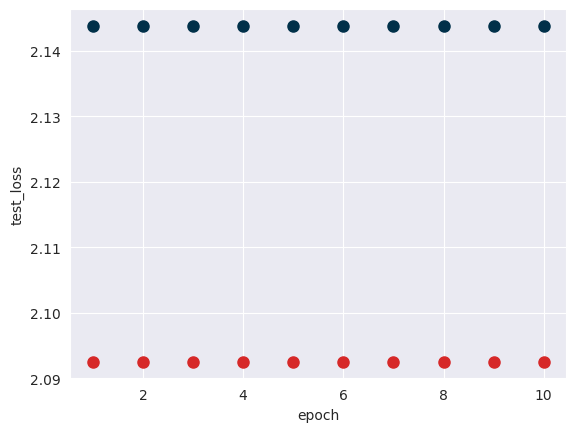

In [24]:
# Plot the average loss per epoch
ax1 = df_eval.plot(kind='scatter', x='epoch', y='train_loss', color=my_palette[0], s=64)
ax2 = df_eval.plot(kind='scatter', x='epoch', y='test_loss', color=my_palette[1], s=64, ax=ax1)

# Save figure
plt.savefig(os.path.join(FIGURE_PATH,'model-eval-loss.pdf'), bbox_inches='tight');

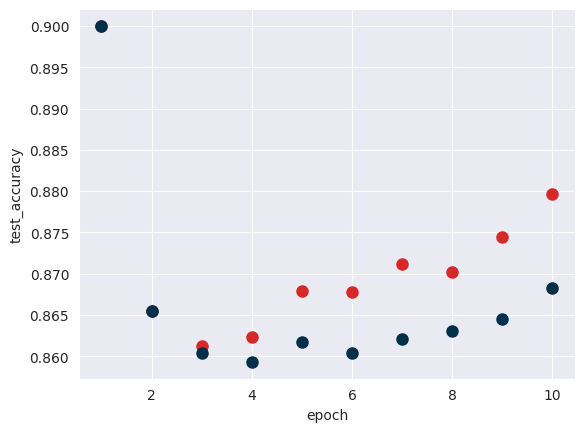

In [25]:
# Plot the accuracy per epoch
ax1 = df_eval.plot(kind='scatter', x='epoch', y='train_accuracy', color=my_palette[0], s=64)
ax2 = df_eval.plot(kind='scatter', x='epoch', y='test_accuracy', color=my_palette[1], s=64, ax=ax1)

# Save figure
plt.savefig(os.path.join(FIGURE_PATH,'model-eval-accuracy.pdf'), bbox_inches='tight');